In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from iso3166 import countries
from datetime import datetime, timedelta

In [2]:
# we set up the floating numbers up to two decimals
pd.options.display.float_format = '{:,.2f}'.format

# we'll load the dataframe and cast the date column to datetime and the price column to float
data_types = {
    'date': 'datetime64'
}
df = pd.read_csv('launchdata.csv', parse_dates=['date'])
df['price'] = df['price'].str.replace(',', '').astype(float)

In [3]:
# let's see if there are any duplicate rows in the dataframe
duplicate_rows = df[df.duplicated()]
print(duplicate_rows)

# check how many values are null in the dataframe
print(df.isnull().sum())

Empty DataFrame
Columns: [date, location, mission_name, mission_status, organization, price, rocket_name, rocket_status]
Index: []
date                 0
location             0
mission_name         0
mission_status       0
organization         0
price             3996
rocket_name          0
rocket_status        0
dtype: int64


In [4]:
# now, we're going to have a look at the descriptive statistics of the dataframe
df.describe()

date    price
count                           6578 2,582.00
mean   1991-01-28 18:59:19.793250304    77.43
min              1957-10-04 19:28:00     2.50
25%              1974-11-15 21:49:30    20.00
50%              1988-03-25 04:59:30    29.75
75%              2008-08-01 07:18:15    67.00
max              2023-09-27 06:00:00 3,000.00
std                              NaN   151.86

In [5]:
# let's have a look at the price only
df.describe(include=[float])

price
count 2,582.00
mean     77.43
std     151.86
min       2.50
25%      20.00
50%      29.75
75%      67.00
max   3,000.00

# Number of Launches per Company

In [6]:
# let's see how many organizations are actually in the dataframe
df['organization'].unique()

array(['ISA', 'Roscosmos', 'ULA', 'SpaceX', 'CASC', 'Firefly',
       'Rocket Lab', 'Galactic Energy', 'NADA', 'ISRO', 'Virgin Galactic',
       'MHI', 'CASIC', 'Northrop', 'VKS RF', 'Landspace', 'Arianespace',
       'KARI', 'ExPace', 'CAS Space', 'Space Pioneer', 'IAI', 'i-Space',
       'ABL SS', 'Virgin Orbit', 'NASA', 'Blue Origin', 'Astra',
       'Starsem', 'OneSpace', 'JAXA', 'Eurockot', 'ILS', 'Sandia',
       'Kosmotras', 'Sea Launch', 'KCST', 'Land Launch', 'Boeing', 'ISAS',
       'MITT', 'SRC', 'Lockheed', 'Scaled', 'ESA', 'AEB', 'EER',
       'General Dynamics', 'Martin Marietta', 'US Air Force', 'RVSN USSR',
       'ASI', 'CNES', 'RAE', 'CECLES', 'UT', 'ABMA', 'OKB-586',
       "Armée de l'Air", 'US Navy', 'Douglas', 'IRGC', 'GK LS',
       'Relativity Space'], dtype=object)

In [7]:
# now that we know which organizations are doing space missions, let's see how many launches each organization has attempted
df['organization'].value_counts()

organization
RVSN USSR           2464
US Air Force         546
CASC                 502
Roscosmos            361
VKS RF               337
                    ... 
OKB-586                1
Sandia                 1
OneSpace               1
ABL SS                 1
Relativity Space       1
Name: count, Length: 64, dtype: int64

In [8]:
# Some info on total launches of some specific organizations
print(f"Number of launches of NASA: {df['organization'].value_counts()['NASA']}")
print(f"Number of launches of ESA: {df['organization'].value_counts()['ESA']}")
print(f"Number of launches of JAXA: {df['organization'].value_counts()['JAXA']}")
print(f"Number of launches of Roscosmos: {df['organization'].value_counts()['Roscosmos']}")
print(f"Number of launches of SpaceX: {df['organization'].value_counts()['SpaceX']}")

Number of launches of NASA: 222
Number of launches of ESA: 14
Number of launches of JAXA: 8
Number of launches of Roscosmos: 361
Number of launches of SpaceX: 278


<Axes: xlabel='organization'>

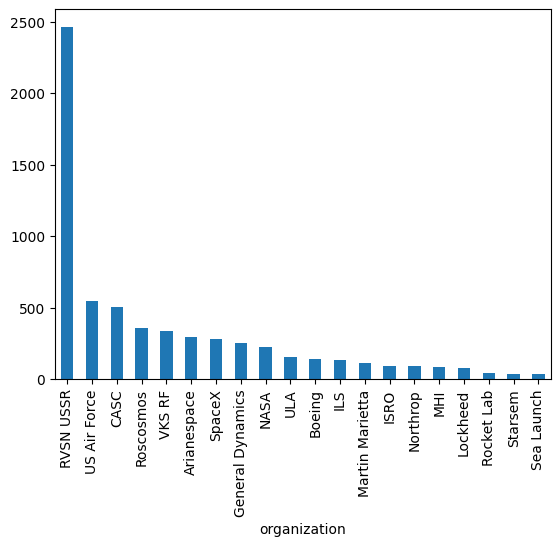

In [10]:
# now, let's see the total launches of the top 20 organization in a bar chart
# we're doing a value counts to get the total number of launches as above, but we keep only the top 20
df['organization'].value_counts().iloc[:20].plot(kind='bar')

# Number of Active and Retired Rockets

<Axes: title={'center': 'Rocket Status'}, ylabel='count'>

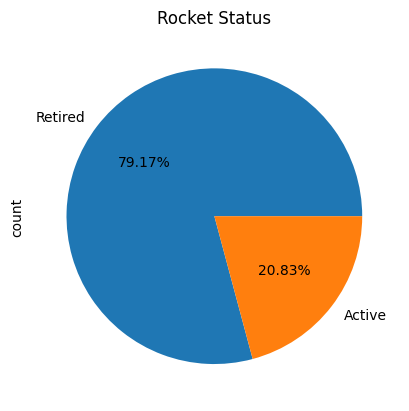

In [9]:
# now, let's see how many rockets are still active
# we're going to get the total number of active vs. retired rockets and plot into a pie. 
# Let's also place the percentage of active/retired rockets on the pie
df['rocket_status'].value_counts().plot(kind='pie', autopct='%1.2f%%', title='Rocket Status')

# Distribution of Mission Status

In [10]:
# now we would like to see what was the outcome of the missions in the dataframe
# first, let's have a look at how many outcome types there are and then let's use value_counts() to see their total each
df['mission_status'].unique()
df['mission_status'].value_counts()

mission_status
Success              6021
Failure               440
Partial Failure       112
Prelaunch Failure       5
Name: count, dtype: int64

<Axes: title={'center': 'Mission Outcome'}, ylabel='count'>

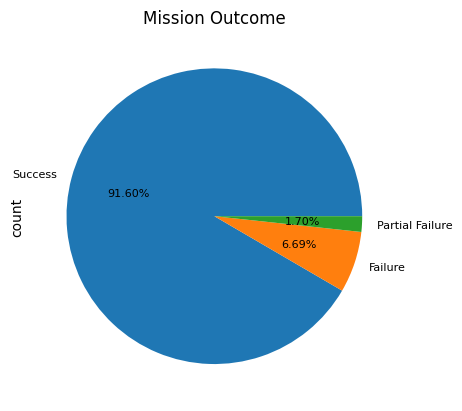

In [13]:
# since prelaunch failure represents a very small number, let's leave it out of the pie chart
df['mission_status'].value_counts().iloc[:3].plot(kind='pie', 
                                                  autopct='%1.2f%%', 
                                                  title='Mission Outcome', 
                                                  textprops={'fontsize':8}, 
                                                  labeldistance=1.1
                                                 )

# Cost of Launches

In [11]:
# before calculating the cost of launches, let's start with a clean dataframe dropping unneeded columns from the original
df_year_price = df.drop(['location', 'mission_name', 'mission_status', 'organization', 'rocket_name', 'rocket_status'],
        axis=1).sort_values(by=['date']).dropna()
df_year_price.head()

date  price
5156 1964-09-01 15:00:00  63.23
5126 1964-12-10 16:53:00  63.23
5087 1965-02-11 15:19:00  63.23
5068 1965-05-06 15:00:00  63.23
4976 1966-07-29 18:30:00  59.00

In [16]:
# let's use groupby() to group the dataframe by year (filtering only for year in the datetime)
# then, we'll use .sum() to see the total amount spent per year
df_year_price.groupby(df_year_price['date'].dt.year)['price'].sum().head()

date
1964     126.46
1965     126.46
1966     177.00
1967   1,514.00
1968   2,792.00
Name: price, dtype: float64

<Axes: xlabel='date'>

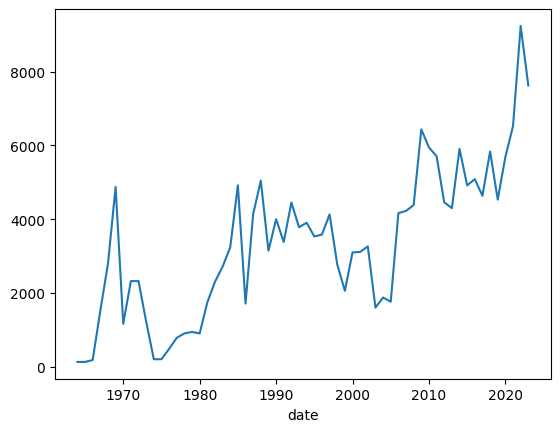

In [12]:
# now that we're sure we're getting some results with the commands above, let's plot them into a line chart
df_year_price.groupby(df_year_price['date'].dt.year)['price'].sum().plot()

# Number of Launches per Country

In [13]:
# let's start with a clean dataframe
df_countries = df

# to get the countries, we're going to use the existing location column (which contains country info)
# we'll split the string in the column on commas (",") and keep the last entry in the list (since the country is last in the string)
df_countries['location'] = df['location'].str.split(',').str[-1].str.strip()
df_countries.head()

date    location             mission_name mission_status  \
0 2023-09-27 06:00:00        Iran                   Nour 3        Success   
1 2023-09-15 15:44:00  Kazakhstan              Soyuz MS-24        Success   
2 2023-09-10 12:47:00         USA  SILENTBARKER (NROL-107)        Success   
3 2023-09-12 06:57:00         USA       Starlink Group 7-2        Success   
4 2023-09-17 04:13:00       China       Yaogan 39 Group 02        Success   

  organization  price       rocket_name rocket_status  
0          ISA    NaN             Qased        Active  
1    Roscosmos  17.42        Soyuz 2.1a        Active  
2          ULA 153.00       Atlas V 551        Active  
3       SpaceX  67.00  Falcon 9 Block 5        Active  
4         CASC  29.75     Long March 2D        Active

In [14]:
# it worked! let's have a look at how many launches took place in each country
df_countries['location'].value_counts()

location
USA                               1989
Russia                            1799
Kazakhstan                        1547
China                              547
France                             323
Japan                              131
India                               91
New Zealand                         38
Pacific Ocean                       36
Iran                                13
Israel                              12
Kenya                                9
Marshall Islands                     9
North Korea                          7
South Korea                          6
Yellow Sea                           6
Australia                            6
Barents Sea                          3
Brazil                               2
Gran Canaria                         2
Pacific Missile Range Facility       1
United Kingdom                       1
Name: count, dtype: int64

In [15]:
# in order to use Plotly to plot the Choropleth map, we'll need to convert the country names to a three letter code
# let's write a helper function leveraging iso3166 to help us do that
def map_to_alpha3_country_code(country_name: str):
    try:
        return countries.get(country_name).alpha3
    except:
        return None

In [16]:
# there's one issue however. Iso3166 expects specific names for the countries. That means we'll need to change some of the ones
# in the dataframe to their official version. In addition, we'll change some sea-based launch locations to the country that performed them
def clean_country_names(country_name: str):
    if country_name == 'Russia':
        return 'Russian Federation'
    if country_name == 'Yellow Sea':
        return 'China'
    if country_name == 'Pacific Missile Range Facility':
        return 'USA'
    if country_name == 'Barents Sea':
        return 'Russian Federation'
    if country_name == 'Gran Canaria':
        return 'USA'
    if country_name == 'United Kingdom':
        return 'United Kingdom of Great Britain and Northern Ireland'
    if country_name == 'North Korea':
        return "Korea, Democratic People's Republic of"
    if country_name == 'South Korea':
        return "Korea, Republic of"
    if country_name == 'Iran':
        return "Iran, Islamic Republic of"
    else:
        return country_name

In [17]:
# now that we have out helper functions, let's use .apply() to apply the clean_country_names function
# to our location column values and clean the names. When done, let's see the results!
df_countries['location'] = df_countries['location'].apply(clean_country_names)
df_countries['location'].value_counts()

location
USA                                                     1992
Russian Federation                                      1802
Kazakhstan                                              1547
China                                                    553
France                                                   323
Japan                                                    131
India                                                     91
New Zealand                                               38
Pacific Ocean                                             36
Iran, Islamic Republic of                                 13
Israel                                                    12
Marshall Islands                                           9
Kenya                                                      9
Korea, Democratic People's Republic of                     7
Korea, Republic of                                         6
Australia                                                  6
Brazil         

In [18]:
# it worked! Let's repeat the same actions, this time converting the names to their three-letter country codes
df_countries['location'] = df_countries['location'].apply(map_to_alpha3_country_code)
df_countries['location'].value_counts()

location
USA    1992
RUS    1802
KAZ    1547
CHN     553
FRA     323
JPN     131
IND      91
NZL      38
IRN      13
ISR      12
MHL       9
KEN       9
PRK       7
KOR       6
AUS       6
BRA       2
GBR       1
Name: count, dtype: int64

In [19]:
# now that we have the codes choropleth requires, let's create a clean dataframe with the number of launches and the countries
# let's also rename the columns in the dataframes to "country" and "launches"
df_countries_launches = pd.DataFrame(df_countries['location'].value_counts())
df_countries_launches = df_countries_launches.reset_index()
df_countries_launches.columns = ['country', 'launches']
df_countries_launches.head()

country  launches
0     USA      1992
1     RUS      1802
2     KAZ      1547
3     CHN       553
4     FRA       323

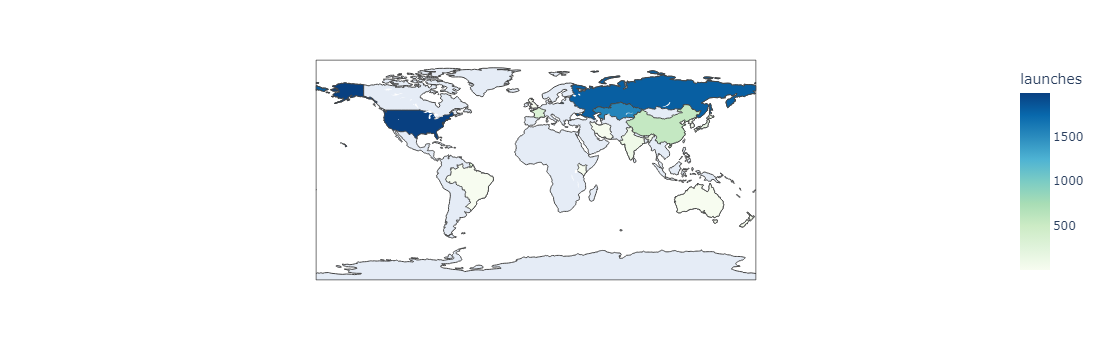

In [20]:
# now, we're ready to plot our choropleth chart using plotly!
fig = px.choropleth(df_countries_launches, locations="country", color='launches',
                    color_continuous_scale=px.colors.sequential.GnBu)
fig.show()

# Number of Failures per Country

In [21]:
# now, let's create a choropleth chart this time mapping the number of failures per country
# first, we'll create a clean dataframe filtered to contain only the launch failures
df_failed = df_countries[df_countries['mission_status'] == 'Failure']

# then, we'll repeat the same process as above
df_failed_launches = pd.DataFrame(df_failed['location'].value_counts())
df_failed_launches = df_failed_launches.reset_index()
df_failed_launches.columns = ['location', 'failed_launches']
df_failed_launches.head()

location  failed_launches
0      USA              157
1      KAZ              113
2      RUS               72
3      CHN               27
4      FRA               15

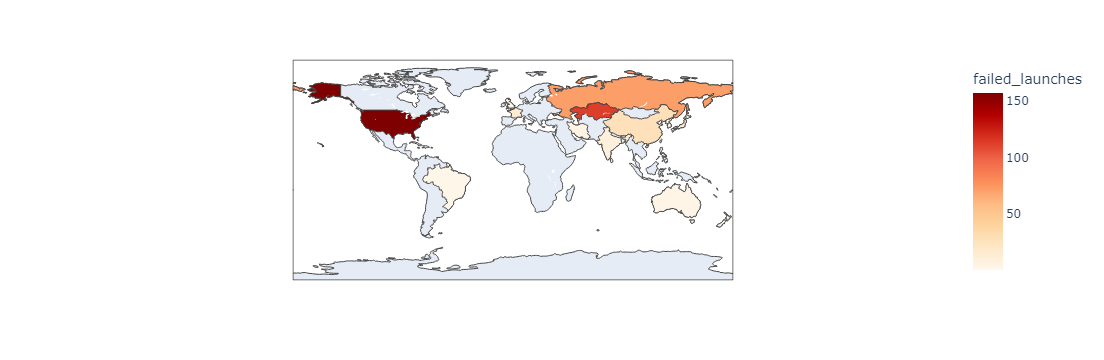

In [22]:
# and we plot the choropleth
fig = px.choropleth(df_failed_launches, locations="location", color='failed_launches',
                    color_continuous_scale=px.colors.sequential.OrRd)
fig.show()

# Total Amount of Money Spent by Organization on Missions

In [23]:
# first, let's see how munch money was spent on missions by each organization
df.groupby('organization')['price'].sum()

organization
ABL SS                12.00
ABMA                   0.00
AEB                    0.00
ASI                    0.00
Arianespace       18,883.00
                     ...   
UT                     0.00
VKS RF             3,335.94
Virgin Galactic        0.00
Virgin Orbit          72.00
i-Space                0.00
Name: price, Length: 64, dtype: float64

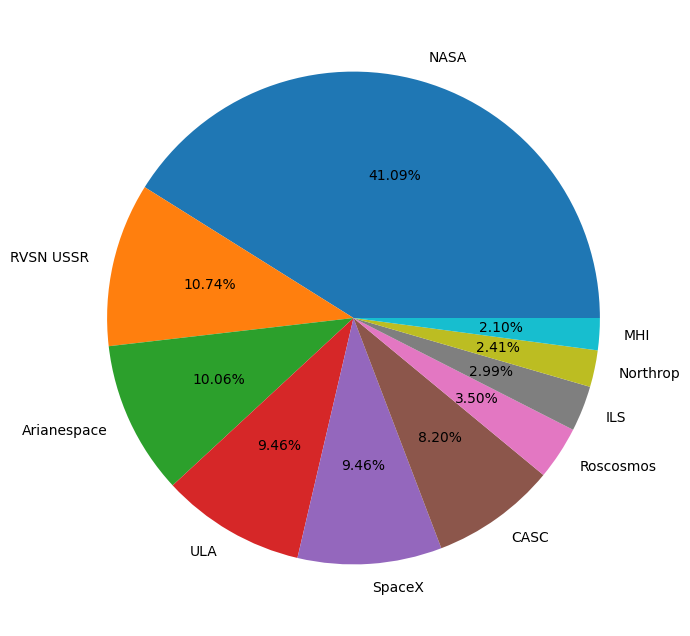

In [24]:
# in order to plot it, let's use clean dataframe using the command above to populate it
df_money_by_organization = df.groupby('organization')['price'].sum().reset_index()
# now, let's sort the dataframe by price and keep only the first 10 organizations
df_money_by_organization = df_money_by_organization.sort_values(by='price', ascending=False)
df_money_by_organization = df_money_by_organization.iloc[:10]

# let's have a look in a pie chart
plt.figure(figsize=(8, 8))
plt.pie(df_money_by_organization['price'], labels=df_money_by_organization['organization'], autopct='%1.2f%%')
plt.show()

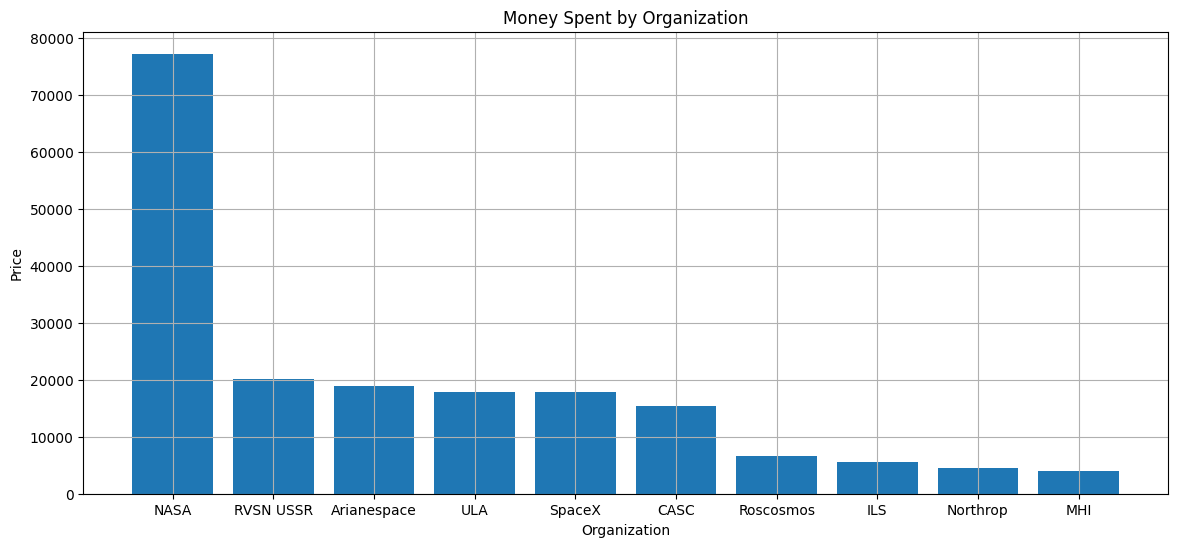

In [25]:
# let's also see it in a bar chart
plt.figure(figsize=(14,6))
plt.bar(df_money_by_organization['organization'], df_money_by_organization['price'])
plt.xlabel('Organization')
plt.ylabel('Price')
plt.title('Money Spent by Organization')
plt.grid(True)
plt.show()

# Amount of Money Spent by Organization per Launch

In [26]:
# as usual, let's start with a clean dataframe filtering out all zero prices
df_nonan = df[df['price'] > 0].reset_index()

# now, we're doing to create a dataframe keeping only the unique values of the organizations
result_df = pd.DataFrame({'organization': df_nonan['organization'].unique()})
# then, using the original dataframe, we'll add a column to our result_df for the money per launch
# to calculate that, we'll use .map() and pass in the .sum() of prices grouped by organization (to see the total amount of money
# each organization spent) and divide with the .count() of the organizations (to calculate how many times an organization appears,
# i.e. how many launches each one attempted)
result_df['price_per_launch'] = result_df['organization'].map(df.groupby('organization')['price'].sum() / df.groupby('organization')['organization'].count())
result_df.head()

organization  price_per_launch
0    Roscosmos             18.21
1          ULA            113.14
2       SpaceX             63.86
3         CASC             30.68
4      Firefly             15.00

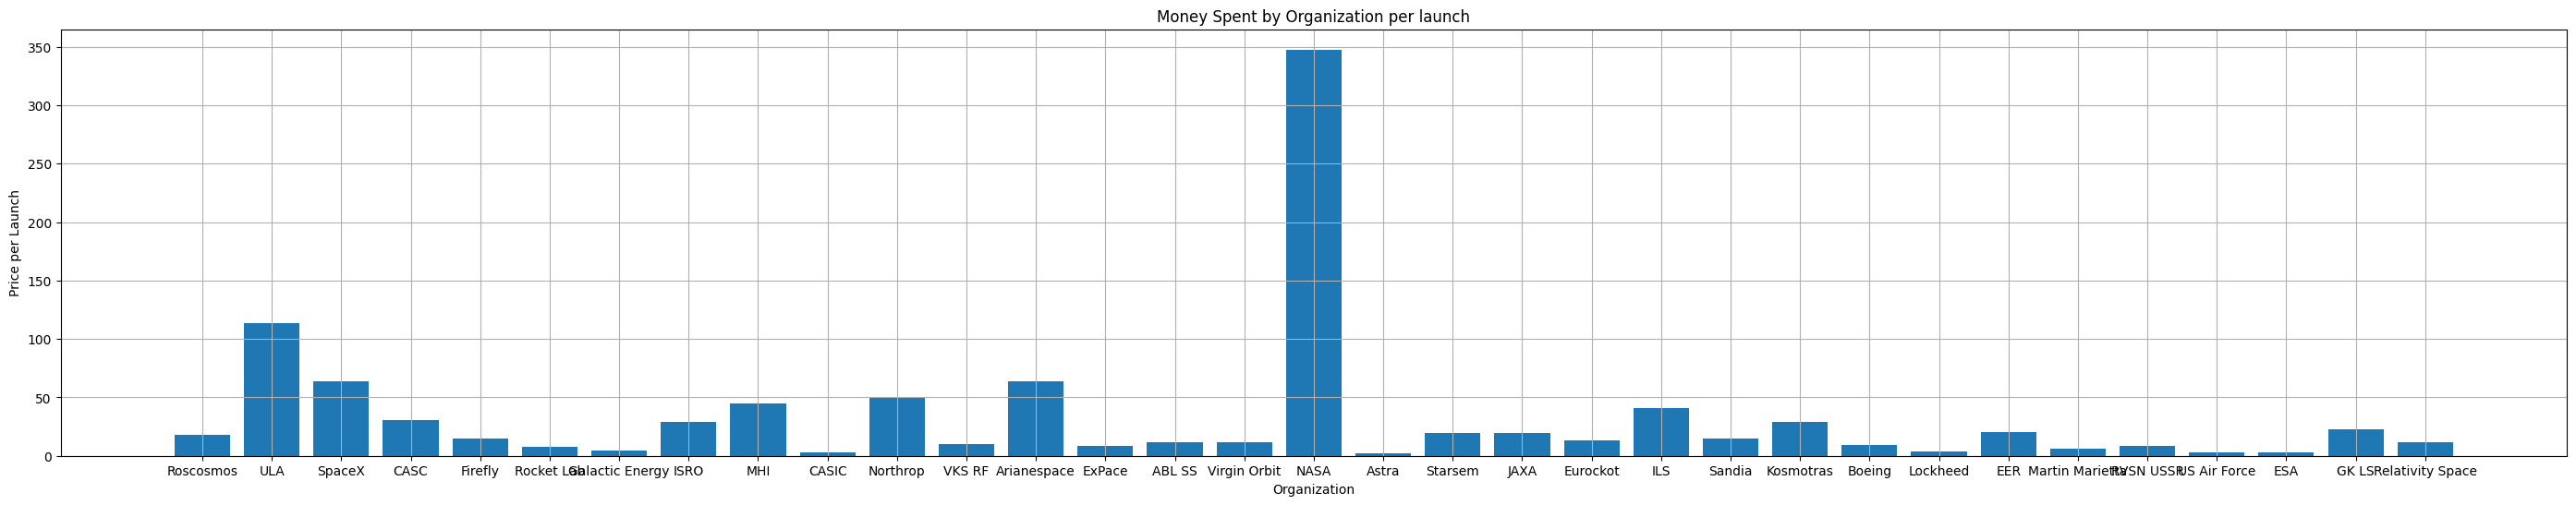

In [27]:
# now we can plot the bar chart
plt.figure(figsize=(35,6))
plt.bar(result_df['organization'], result_df['price_per_launch'])
plt.xlabel('Organization')
plt.ylabel('Price per Launch')
plt.title('Money Spent by Organization per launch')
plt.grid(True)
plt.show()

# Number of Launches per Year

In [28]:
# let's start with a clean dataframe. Let's add a column containing only the year value of the datetime
# and then sort by year. Each time a year appears in a row is a launch, so, if we use .value_counts()
# we can find out how many launches were attempted each year
df_years = df
df_years['year'] = df['date'].dt.strftime('%Y')
df_years = df_years.sort_values('year')
df_years['year'].value_counts().sort_index()

year
1957      3
1958     22
1959     24
1960     41
1961     56
       ... 
2019    106
2020    118
2021    156
2022    190
2023    165
Name: count, Length: 67, dtype: int64

<Axes: xlabel='year'>

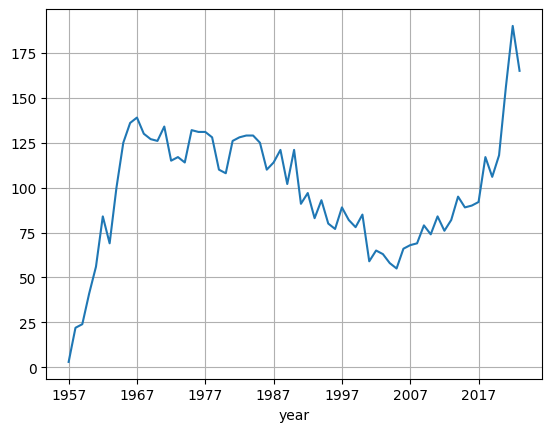

In [29]:
# let's plot it
df_years['year'].value_counts().sort_index().plot(grid=True)

# Number of Launches Month-on-Month until the Present

In [30]:
# to get the month-on-month, let's use dt.to_period(), passing month ('M') as a parameter to keep year and month from datetime
df_years['date'].dt.to_period('M').value_counts().sort_index()

date
1957-10     1
1957-11     1
1957-12     1
1958-02     2
1958-03     3
           ..
2023-05    21
2023-06    15
2023-07    18
2023-08    23
2023-09    23
Freq: M, Name: count, Length: 788, dtype: int64

<Axes: xlabel='date'>

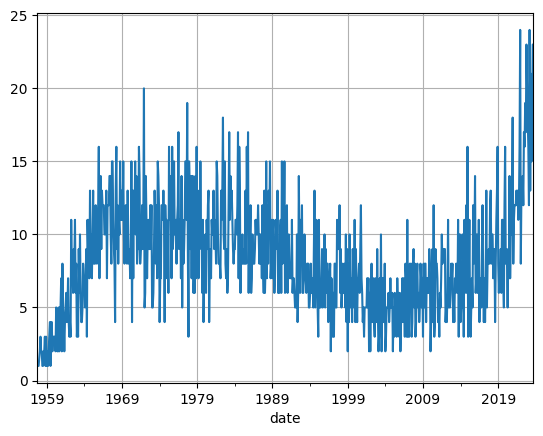

In [31]:
# as with the previous one, each row is a launch in the dataframe, so we can plot using value_counts()
df_years['date'].dt.to_period('M').value_counts().sort_index().plot(grid=True)

# Most and Least Popular Month for Launching

<Axes: xlabel='Month', ylabel='Launches'>

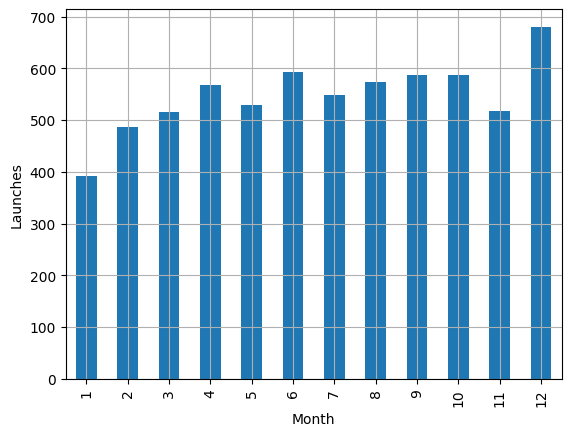

In [32]:
# to see the most popular months for launching, we use dt.month.value_counts() to get the total number each month
# appears in the dataframe. Since each entry represents a launch, we can plot a bar chart
df_years['date'].dt.month.value_counts().sort_index().plot(kind='bar', grid=True, xlabel='Month', ylabel='Launches')

# Launch Price over Time

In [33]:
# to get the launch price over time, let's start with a clean dataframe filtering out all null price values
df_price_over_time = df[df['price'] > 0].reset_index()

# now, we can create the dataframe using only the year and the price as columns
df_price_over_time = pd.DataFrame({'date': df_price_over_time['date'].dt.year,
                                   'price': df_price_over_time['price']})
# now that the dataframe is created, we'll group by 'date' and the calculate the .mean() of the prices each 'date' value has
average_price_per_year = df_price_over_time.groupby('date')['price'].mean().reset_index().sort_index()
average_price_per_year.head()

date  price
0  1964  63.23
1  1965  63.23
2  1966  59.00
3  1967 216.29
4  1968 279.20

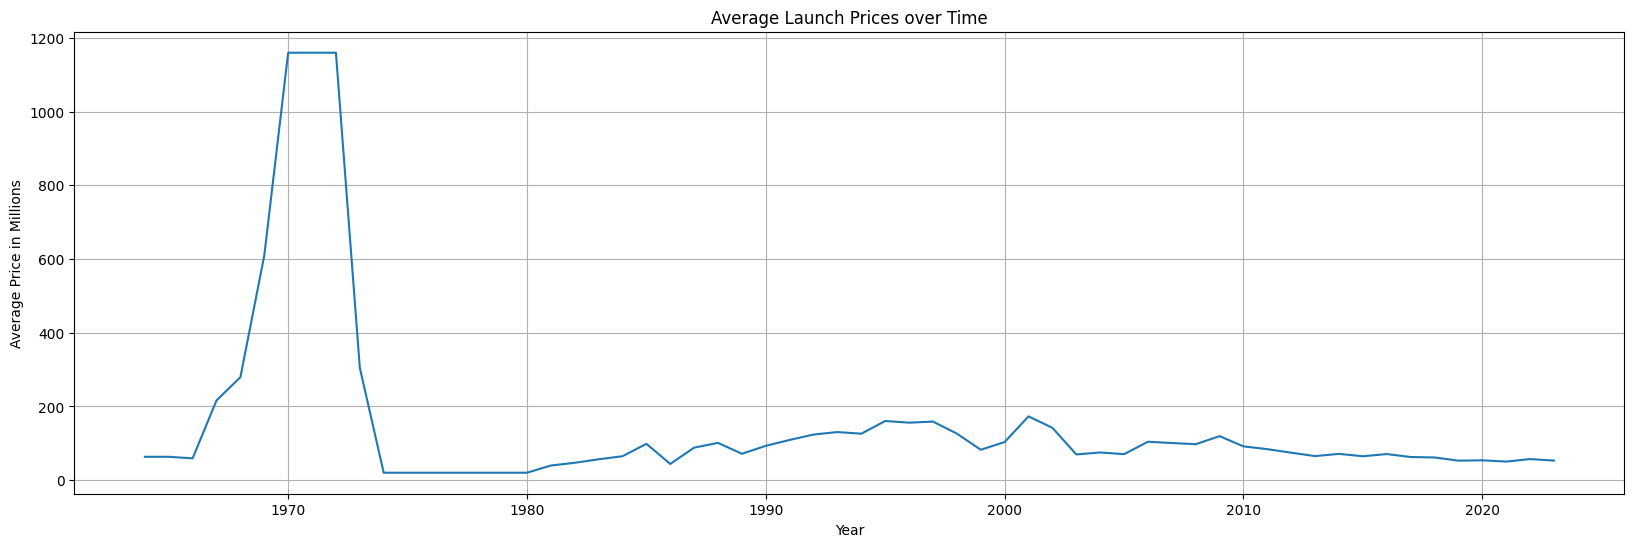

In [34]:
# let's plot it
plt.figure(figsize=(20,6))
plt.plot(average_price_per_year['date'], average_price_per_year['price'])
plt.xlabel('Year')
plt.ylabel('Average Price in Millions')
plt.title('Average Launch Prices over Time')
plt.grid(True)
plt.show()

# Number of Launches over Time by the Top 10 Organizations

In [35]:
# first, let's see which are the top 10 organization in terms of launches
df['organization'].value_counts().sort_values(ascending=False).iloc[:10]

organization
RVSN USSR           2464
US Air Force         546
CASC                 502
Roscosmos            361
VKS RF               337
Arianespace          296
SpaceX               278
General Dynamics     250
NASA                 222
ULA                  157
Name: count, dtype: int64

In [36]:
# now, let's place them in a list and then create a clean dataframe from the original one using
# .isin() to keep only the top 10
top_10_organizations = df['organization'].value_counts().sort_values(ascending=False).iloc[:10].index
df_top_10 = df[df['organization'].isin(top_10_organizations)]
df_top_10.reset_index().head()

index                date location             mission_name mission_status  \
0      1 2023-09-15 15:44:00      KAZ              Soyuz MS-24        Success   
1      2 2023-09-10 12:47:00      USA  SILENTBARKER (NROL-107)        Success   
2      3 2023-09-12 06:57:00      USA       Starlink Group 7-2        Success   
3      4 2023-09-17 04:13:00      CHN       Yaogan 39 Group 02        Success   
4      6 2023-09-20 03:38:00      USA      Starlink Group 6-17        Success   

  organization  price       rocket_name rocket_status  year  
0    Roscosmos  17.42        Soyuz 2.1a        Active  2023  
1          ULA 153.00       Atlas V 551        Active  2023  
2       SpaceX  67.00  Falcon 9 Block 5        Active  2023  
3         CASC  29.75     Long March 2D        Active  2023  
4       SpaceX  67.00  Falcon 9 Block 5        Active  2023

In [38]:
# now that we have the top 10, let's use groupby() to group for each organization and year
# after that, we pivot the dataframe placing the organizations as columns and the number of launches as values in each year
# for each organization. If there is no count, then we place 0 to denote that the organization didn't perform any launches
organizations_years = df_top_10.groupby(['year', 'organization']).size().reset_index(name='count')
pivot_organizations_years = organizations_years.pivot(index='year', columns='organization', values='count').fillna(0)

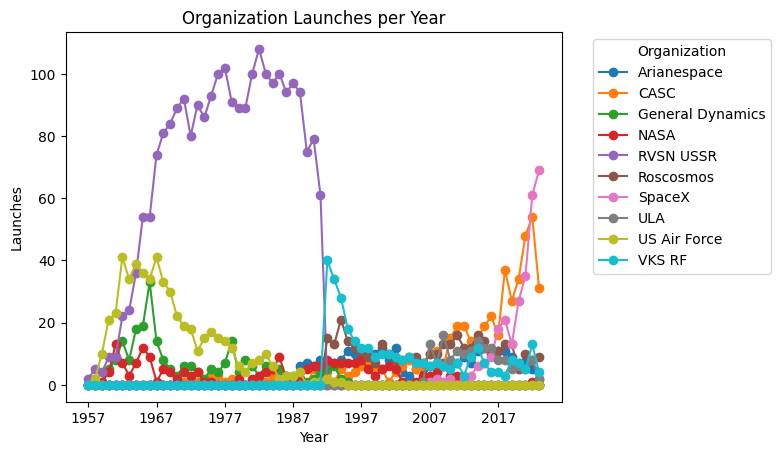

In [39]:
# now, let's plot it!
pivot_organizations_years.plot(kind='line', marker='o')
plt.xlabel('Year')
plt.ylabel('Launches')
plt.title('Organization Launches per Year')
plt.legend(title='Organization', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Cold War Space Race

In [40]:
# the Cold War started from the start of the dataframe to 1991. Let's use .query() to filter for dates until 1991
# because I've messed with the dataframe a lot so far, let's reload it ;)

data_types = {'date': 'datetime64'}
df_reloaded = pd.read_csv('launchdata.csv', parse_dates=['date'])
df_reloaded['price'] = df_reloaded['price'].str.replace(',', '').astype(float)

df_cold_war = df_reloaded.query("date < '1991-12-31' and date >= '1948-01-01'")
df_cold_war.reset_index()

index                date  \
0      2391 1991-10-23 15:25:00   
1      2392 1991-11-08 07:07:00   
2      2393 1991-10-29 23:08:00   
3      2394 1991-11-12 20:09:00   
4      2395 1991-11-22 13:27:00   
...     ...                 ...   
3693   6094 1991-09-28 07:05:00   
3694   6095 1991-10-02 05:59:00   
3695   6096 1991-10-04 18:09:00   
3696   6097 1991-10-10 14:00:00   
3697   6098 1991-10-09 13:15:00   

                                               location         mission_name  \
0          Site 200/39, Baikonur Cosmodrome, Kazakhstan          Gorizont 24   
1               SLC-4E, Vandenberg SFB, California, USA     SLDCOM & NOSS 3x   
2     ELA-2, Guiana Space Centre, French Guiana, France        Intelsat 6AF1   
3                Site 32/1, Plesetsk Cosmodrome, Russia  Cosmos 2165 to 2170   
4           Site 81/23, Baikonur Cosmodrome, Kazakhstan          Cosmos 2172   
...                                                 ...                  ...   
3693             Site 32/2, Plesetsk Cosmodrome, Russia  Cosmos 2157 to 2162   
3694          Site 1/5, Baikonur Cosmodrome, Kazakhstan          Soyuz TM-13   
3695             Site 43/4, Plesetsk Cosmodrome, Russia              Foton 7   
3696            Site 132/1, Plesetsk Cosmodrome, Russia          Cosmos 2164   
3697          Site 1/5, Baikonur Cosmodrome, Kazakhstan          Cosmos 2163   

     mission_status     organization  price          rocket_name rocket_status  
0           Success        RVSN USSR    NaN  Proton K/Block-DM-2       Retired  
1           Success  Martin Marietta    NaN       Titan IV(403)A       Retired  
2           Success      Arianespace    NaN           Ariane 44L       Retired  
3           Success        RVSN USSR    NaN            Tsyklon-3       Retired  
4           Success        RVSN USSR    NaN  Proton K/Block-DM-2       Retired  
...             ...              ...    ...                  ...           ...  
3693        Success        RVSN USSR    NaN            Tsyklon-3       Retired  
3694        Success        RVSN USSR  40.00             Soyuz U2       Retired  
3695        Success        RVSN USSR  20.00              Soyuz U       Retired  
3696        Success        RVSN USSR    NaN            Cosmos-3M       Retired  
3697        Success        RVSN USSR  40.00             Soyuz U2       Retired  

[3698 rows x 9 columns]

# Total Number of Launches by USSR and USA

In [41]:
# let's use .copy() to work with a clean dataframe. Let's use the same method used way back to clean for country names
df_cold_war_countries = df_cold_war.copy()
df_cold_war_countries['location'] = df_cold_war['location'].str.split(',').str[-1].str.strip()

In [42]:
# since some present-day countries were part of the Soviet Union during the Cold War,
# let's write a helper function that changes their names to USSR
def cold_war_country_names(country_name: str):
    if country_name == 'Russia':
        return 'USSR'
    if country_name == 'Kazakhstan':
        return 'USSR'
    if country_name == 'Yellow Sea':
        return 'China'
    if country_name == 'Pacific Missile Range Facility':
        return 'USA'
    if country_name == 'Barents Sea':
        return 'USSR'
    if country_name == 'Gran Canaria':
        return 'USA'
    else:
        return country_name

In [43]:
# now, let's change the values of the 'location' column to the Cold War ones
df_cold_war_countries['location'] = df_cold_war_countries['location'].apply(cold_war_country_names)

# let's also get the next chart to have 'red' and 'blue' colors to be in the Cold War spirit
colors = ['red', 'blue']

<Axes: title={'center': 'Superpower Launches'}, ylabel='count'>

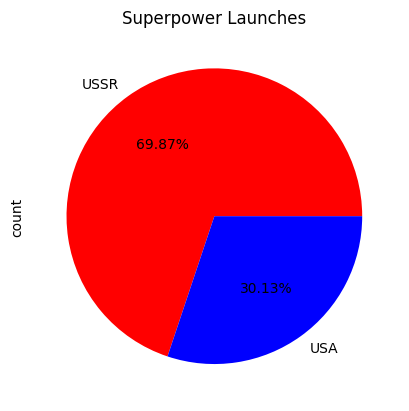

In [53]:
# now, let's see which superpower had the most launches using .value_counts(). Let's also limit to the first two entries
# of the list because other countries also had space programs during the Cold War (e.g. France)
df_cold_war_countries['location'].value_counts().iloc[:2].plot(kind='pie', 
                                                               autopct='%1.2f%%', 
                                                               title='Superpower Launches',
                                                               colors=colors
                                                              )

# Total Number of Launches Year-on-Year by USSR and USA

In [44]:
# to get the total number of launches year-on-year, let's get the values for the two superpowers
# then, let's filter the dataframe to keep only the rows the contain the superpowers (maybe I should have done this before :P )
superpowers = df_cold_war_countries['location'].value_counts().sort_values(ascending=False).iloc[:2].index
df_superpowers = df_cold_war_countries[df_cold_war_countries['location'].isin(superpowers)]
df_superpowers.head()

date location         mission_name mission_status  \
2391 1991-10-23 15:25:00     USSR          Gorizont 24        Success   
2392 1991-11-08 07:07:00      USA     SLDCOM & NOSS 3x        Success   
2394 1991-11-12 20:09:00     USSR  Cosmos 2165 to 2170        Success   
2395 1991-11-22 13:27:00     USSR          Cosmos 2172        Success   
2396 1991-11-24 23:44:00      USA               STS-44        Success   

         organization  price             rocket_name rocket_status  
2391        RVSN USSR    NaN     Proton K/Block-DM-2       Retired  
2392  Martin Marietta    NaN          Titan IV(403)A       Retired  
2394        RVSN USSR    NaN               Tsyklon-3       Retired  
2395        RVSN USSR    NaN     Proton K/Block-DM-2       Retired  
2396             NASA 450.00  Space Shuttle Atlantis       Retired

In [45]:
# now, let's add a column containing the year only to the dataframe
df_superpowers = df_superpowers.copy()
df_superpowers['year'] = pd.to_datetime(df_superpowers['date']).dt.year

In [46]:
# now, like we did when we ploted the organizations year-on-year, we'll groupby() year and location
# and then pivot the table on location filling non-counts with 0
superpower_years = df_superpowers.groupby(['year', 'location']).size().reset_index(name='count')
pivot_superpower_years = superpower_years.pivot(index='year', columns='location', values='count').fillna(0)

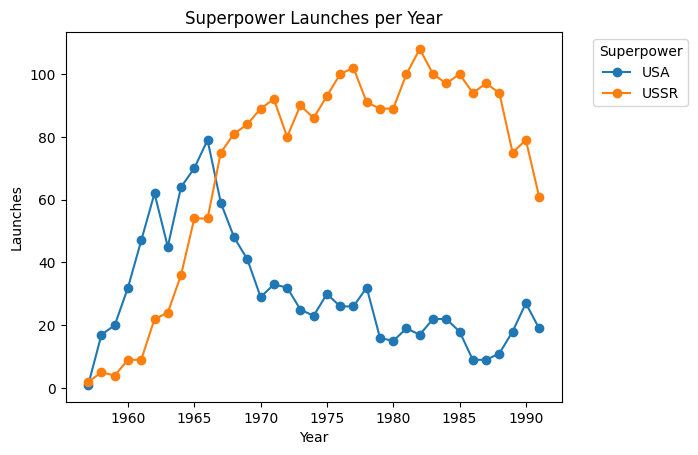

In [47]:
# let's plot it
pivot_superpower_years.plot(kind='line', marker='o')
plt.xlabel('Year')
plt.ylabel('Launches')
plt.title('Superpower Launches per Year')
plt.legend(title='Superpower', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Total Number of Mission Failures Year-on-Year

In [48]:
# to calculate the mission failures year-on-year, let's filter the dataframe to have only the failures
df_superpowers_failure = df_superpowers.copy()
df_superpowers_failure = df_superpowers_failure[df_superpowers_failure['mission_status'] == 'Failure'].reset_index()
df_superpowers_failure.head()

index                date location      mission_name mission_status  \
0   2437 1991-08-30 08:58:00     USSR    Tselina-2 n°09        Failure   
1   2456 1991-04-18 23:30:00      USA           Yuri 3H        Failure   
2   2507 1990-10-04 04:27:00     USSR    Tselina-2 n°08        Failure   
3   2532 1990-07-03 19:19:00     USSR  Yantar-4K2 n°122        Failure   
4   2547 1990-03-14 11:52:00      USA      Intelsat 603        Failure   

       organization  price           rocket_name rocket_status  year  
0         RVSN USSR    NaN               Zenit-2       Retired  1991  
1  General Dynamics    NaN               Atlas I       Retired  1991  
2         RVSN USSR    NaN               Zenit-2       Retired  1990  
3         RVSN USSR  20.00               Soyuz U       Retired  1990  
4   Martin Marietta 136.60  Commercial Titan III       Retired  1990

In [50]:
# now, we'll use the same method as before to group and pivot the table
failure_years = df_superpowers_failure.groupby(['year', 'location']).size().reset_index(name='count')
pivot_failure_years = failure_years.pivot(index='year', columns='location', values='count').fillna(0)

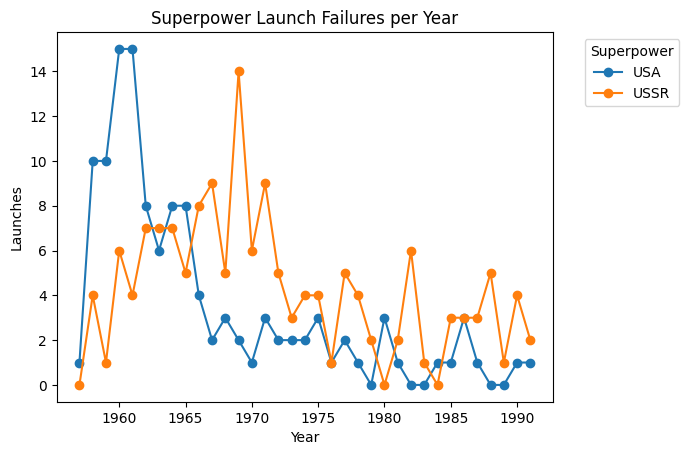

In [51]:
# let's plot it
pivot_failure_years.plot(kind='line', marker='o')
plt.xlabel('Year')
plt.ylabel('Launches')
plt.title('Superpower Launch Failures per Year')
plt.legend(title='Superpower', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Percentage of Failures over Time

In [53]:
# let's get the clean the dataframe and filter only for the superpowers and the year
df_cold_war_countries = df_cold_war_countries[df_cold_war_countries['location'].isin(['USSR', 'USA'])]
df_cold_war_countries['year'] = pd.to_datetime(df_cold_war_countries['date']).dt.year
df_cold_war_countries.head()

date location         mission_name mission_status  \
2391 1991-10-23 15:25:00     USSR          Gorizont 24        Success   
2392 1991-11-08 07:07:00      USA     SLDCOM & NOSS 3x        Success   
2394 1991-11-12 20:09:00     USSR  Cosmos 2165 to 2170        Success   
2395 1991-11-22 13:27:00     USSR          Cosmos 2172        Success   
2396 1991-11-24 23:44:00      USA               STS-44        Success   

         organization  price             rocket_name rocket_status  year  
2391        RVSN USSR    NaN     Proton K/Block-DM-2       Retired  1991  
2392  Martin Marietta    NaN          Titan IV(403)A       Retired  1991  
2394        RVSN USSR    NaN               Tsyklon-3       Retired  1991  
2395        RVSN USSR    NaN     Proton K/Block-DM-2       Retired  1991  
2396             NASA 450.00  Space Shuttle Atlantis       Retired  1991

In [54]:
# now, let's use groupby() to group the table by year and location. Then we use .apply() to the 'mission_status' 
# passing a lambda function that calculates the percentage of failures of the total number of launches
cold_war_grouped_df = df_cold_war_countries.groupby(['year', 'location'])['mission_status'].apply(lambda x: (x == 'Failure').mean() * 100).unstack()

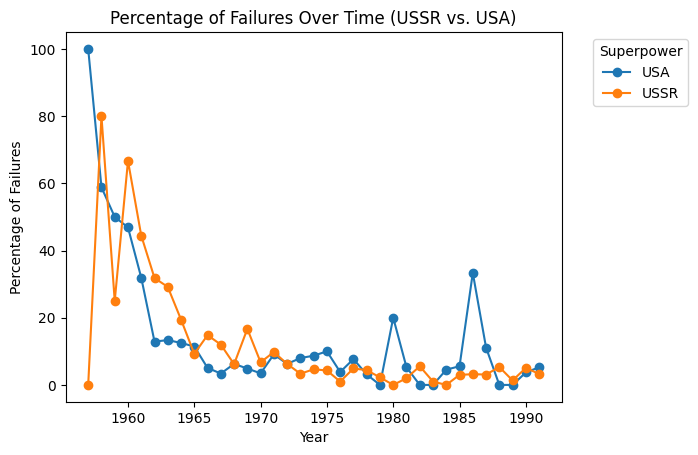

In [55]:
# now, we plot it
cold_war_grouped_df.plot(kind='line', marker='o')
plt.xlabel('Year')
plt.ylabel('Percentage of Failures')
plt.title('Percentage of Failures Over Time (USSR vs. USA)')
plt.legend(title='Superpower', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Country with the Most Number of Launches each Year

In [57]:
# first, let's reload the dataframe to start clean
# and add a column to the original dataframe with the year

df_number_of_launches = pd.read_csv('launchdata.csv', parse_dates=['date'])
df_number_of_launches['price'] = df_number_of_launches['price'].str.replace(',', '').astype(float)
df_number_of_launches['year'] = pd.to_datetime(df['date']).dt.year
df_number_of_launches.head()

date                                          location  \
0 2023-09-27 06:00:00  Launch Platform, Shahrud Missile Test Site, Iran   
1 2023-09-15 15:44:00        Site 31/6, Baikonur Cosmodrome, Kazakhstan   
2 2023-09-10 12:47:00          SLC-41, Cape Canaveral SFS, Florida, USA   
3 2023-09-12 06:57:00           SLC-4E, Vandenberg SFB, California, USA   
4 2023-09-17 04:13:00      LC-3, Xichang Satellite Launch Center, China   

              mission_name mission_status organization  price  \
0                   Nour 3        Success          ISA    NaN   
1              Soyuz MS-24        Success    Roscosmos  17.42   
2  SILENTBARKER (NROL-107)        Success          ULA 153.00   
3       Starlink Group 7-2        Success       SpaceX  67.00   
4       Yaogan 39 Group 02        Success         CASC  29.75   

        rocket_name rocket_status  year  
0             Qased        Active  2023  
1        Soyuz 2.1a        Active  2023  
2       Atlas V 551        Active  2023  
3  Falcon 9 Block 5        Active  2023  
4     Long March 2D        Active  2023

In [61]:
# now, let's get clean and get the country names as we did previously
df_countries_leading = df_number_of_launches.copy()
df_countries_leading['location'] = df_number_of_launches['location'].str.split(',').str[-1].str.strip()
df_countries_leading['location'] = df_countries_leading['location'].apply(clean_country_names)

In [62]:
# now, let's get the launch count of each year by the country with the most launches
countries_launch_counts = df_countries_leading.groupby(['year', 'location']).size().reset_index(name='launch_count')
country_idx = countries_launch_counts.groupby('year')['launch_count'].idxmax()
df_country_most_launches = countries_launch_counts.loc[country_idx]

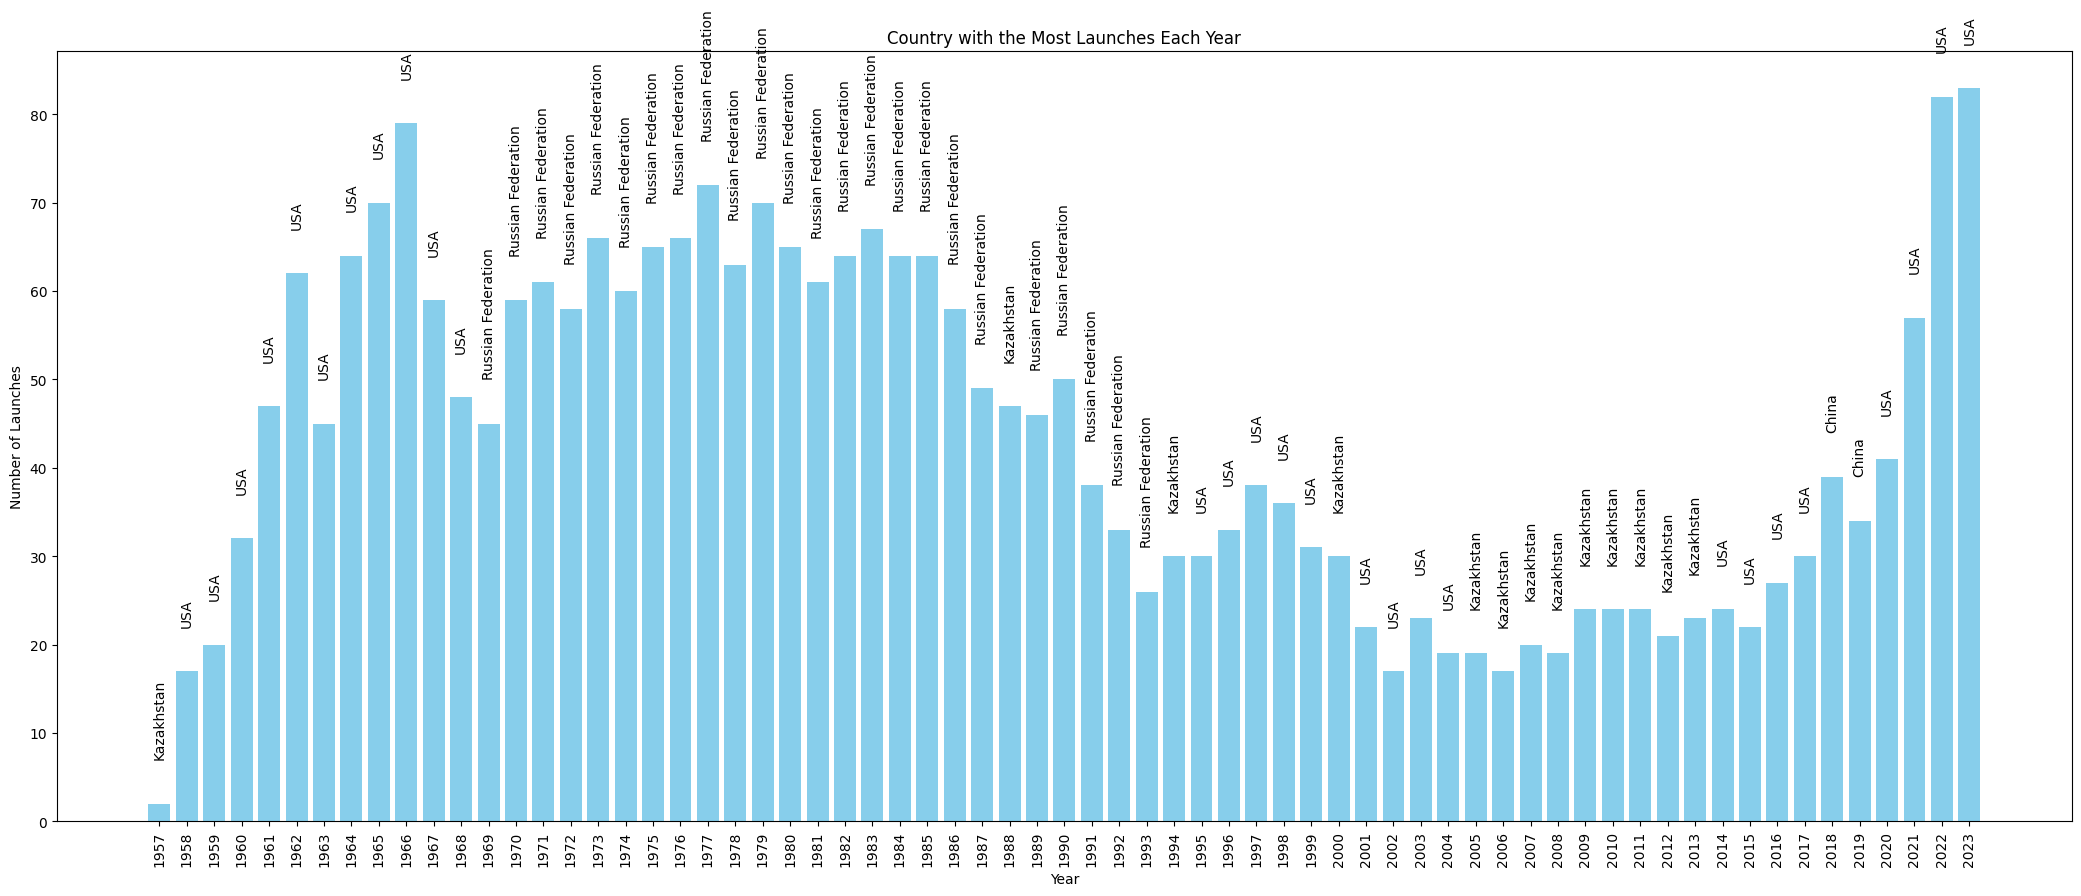

In [63]:
# we chart it in a bar chart
plt.figure(figsize=(26, 10))
bars = plt.bar(df_country_most_launches['year'], df_country_most_launches['launch_count'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.title('Country with the Most Launches Each Year')
plt.xticks(df_country_most_launches['year'], rotation=90)

for bar, label in zip(bars, df_country_most_launches['location']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, label, ha='center', va='bottom', rotation=90)

plt.show()

# Organization with the Most Number of Launches each Year

In [64]:
# we repeat the same process, this time by organization
launch_counts = df_number_of_launches.groupby(['year', 'organization']).size().reset_index(name='launch_count')
idx = launch_counts.groupby('year')['launch_count'].idxmax()
df_most_launches = launch_counts.loc[idx]

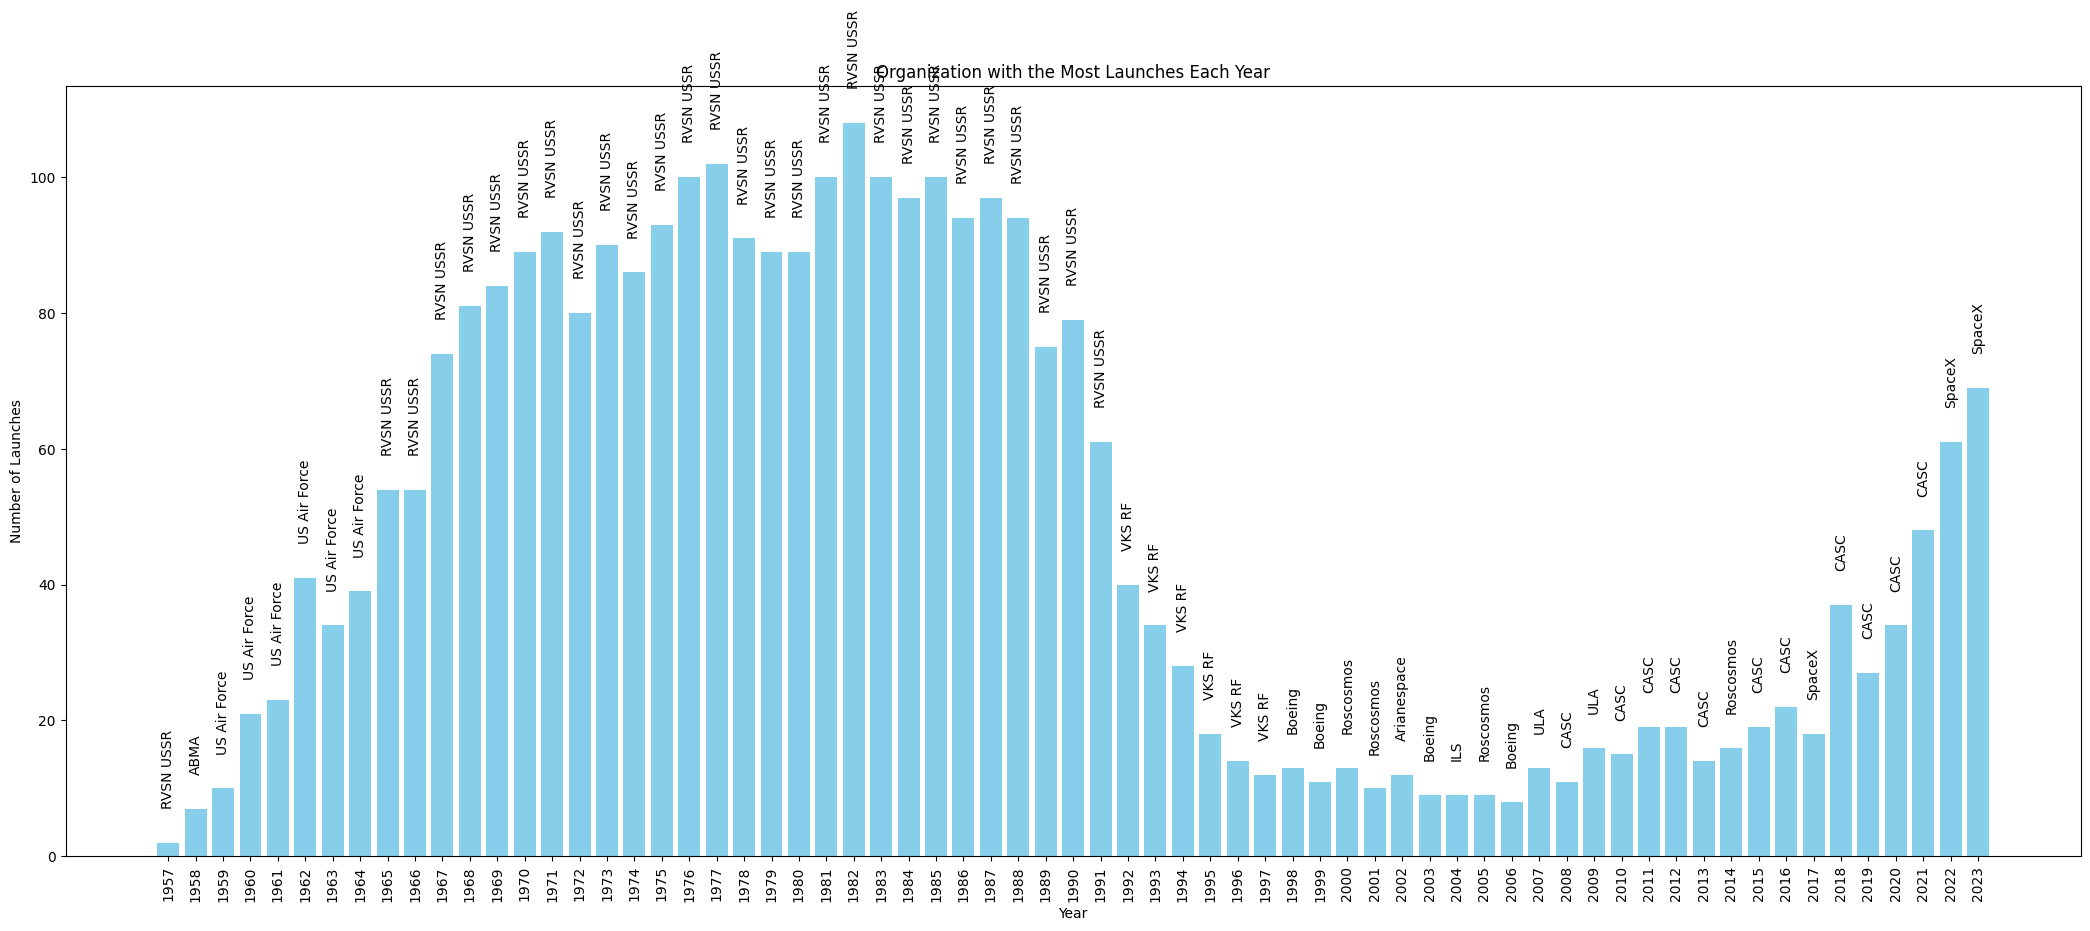

In [65]:
# we chart it in a bar chart
plt.figure(figsize=(26, 10))
bars = plt.bar(df_most_launches['year'], df_most_launches['launch_count'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.title('Organization with the Most Launches Each Year')
plt.xticks(df_most_launches['year'], rotation=90)

for bar, label in zip(bars, df_most_launches['organization']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, label, ha='center', va='bottom', rotation=90)

plt.show()